# Let's compare 4 different strategies to solve sentiment analysis:

1. **Custom model using open source package**. Build a custom model using scikit-learn and TF-IDF features on n-grams. This method is known to work well for English text.
2. **Integrate** a pre-built API. The "sentiment HQ" API provided by indico has been shown to achieve state-of-the-art accuracy, using a recurrent neural network.
3. **Word-level features**. A custom model, built from word-level text features from indico's "text features" API.
4. **RNN features**. A custom model, using transfer learning, using the recurrent features from indico's sentiment HQ model to train a new custom model.

Note: this notebook and the enclosed code snippets accompany the KDnuggets post:
### Semi-supervised feature transfer: the big practical benefit of deep learning today?
<img src="header.jpg">

### Download the data

1. Download the "Large Movie Review Dataset" from http://ai.stanford.edu/~amaas/data/sentiment/. 
2. Decompress it.
3. Put it into some directory path that you define below.

Citation: Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

### User parameters

In [1]:
seed = 3          # for reproducibility across experiments, just pick something
train_num = 100   # number of training examples to use
test_num = 100    # number of examples to use for testing
base_model_name = "sentiment_train%s_test%s" % (train_num, test_num)
lab2bin = {'pos': 1, 'neg': 0}  # label -> binary class
pos_path = "~DATASETS/aclImdb/train/pos/"  # filepath to the positive examples
neg_path = "~DATASETS/aclImdb/train/neg/" # file path to the negative examples
output_path = "CUSTOM_SENTIMENT_OUTPUT"   # path where output file should go
batchsize = 25  # send this many requests at once
max_num_examples = 25000.0   # for making subsets below

### Setup and imports
Install modules as needed (for example: `pip install indicoio`)

In [2]:
import os, io, glob, random, time
# from itertools import islice, chain, izip_longest
import numpy as np
import pandas as pd
from tqdm import tqdm
import pprint
pp = pprint.PrettyPrinter(indent=4)

import indicoio
from indicoio.custom import Collection
from indicoio.custom import collections as check_status

import sklearn
from sklearn import metrics
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt  # for plotting results
%matplotlib inline
import seaborn   # just for the colors

### Define your indico API key
If you don't have a (free) API key, you can [get one here](https://indico.io/pay-per-call). Your first 10,000 calls per months are free.

In [3]:
indicoio.config.api_key = ""  # Add your API key here

### Convenience function for making batches of examples

In [4]:
def batcher(seq, stride = 4):
    """
    Generator strides across the input sequence, 
    combining the elements between each stride.
    """
    for pos in xrange(0, len(seq), stride):
        yield seq[pos : pos + stride] 

In [5]:
# for making subsets below
train_subset = (train_num / 25000.0)
test_subset =  (test_num / 25000.0)

In [6]:
random.seed(seed)
np.random.seed(seed)

### Check that the requested paths exist

In [7]:
# check that paths exist
for p in [pos_path, neg_path]:
    abs_path = os.path.abspath(p)
    if not os.path.exists(abs_path): 
        os.makedirs(abs_path)    
    print(abs_path)
for p in [output_path]:
    abs_path = os.path.abspath(p)
    if not os.path.exists(abs_path):  # and make output path if necessary
        os.makedirs(abs_path)
    print(abs_path)

/Users/djk/DATASETS/SENTIMENT/aclImdb/train/pos
/Users/djk/DATASETS/SENTIMENT/aclImdb/train/neg
/Users/djk/Documents/INDICO/CONTENT/KDN/CUSTOM_SENTIMENT_OUTPUT


### Query indico API to make sure everything is plumbed up correctly

In [8]:
# pre_status = check_status()
# pp.pprint(pre_status)

### Read data into a list of dictionary objects
where each dictionary object will be a single example. This makes it easy to manipulate later using dataframes, for cross-validation, visualization, etc.

### This dataset has pre-defined train/test splits
so rather than sampling our own, we'll use the existing splits to enable fair comparison with other published results.

In [9]:
train_data = []  # these lists will contain a bunch of little dictionaries, one for each example
test_data = []

In [10]:
# Positive examples (train)
examples = glob.glob(os.path.join(pos_path, "*"))  # find all the positive examples, and read them
i = 0
for ex in examples:
    d = {}
    with open(ex, 'rb') as f:
        d['label'] = 'pos'    # label as "pos"
        t = f.read().lower()  # these files are already ascii text, so just lowercase them
        d['text'] = t     
        d['pred_label'] = None   # placeholder for predicted label
        d['prob_pos'] = None     # placeholder for predicted probability of a positive label
    train_data.append(d)  # add example to the list of training data
    i +=1
print("Read %d positive training examples, of %d available (%.2f%%)" % (i, len(examples), (100.0*i)/len(examples)))

Read 12500 positive training examples, of 12500 available (100.00%)


In [11]:
# Negative examples (train)
examples = glob.glob(os.path.join(neg_path, "*"))  # find all the negative examples and read them
i = 0
for ex in examples:
    d = {}
    with open(ex, 'rb') as f:
        d['label'] = 'neg'
        t = f.read().lower()
        d['text'] = t
        d['pred_label'] = None
        d['prob_pos'] = None
    train_data.append(d)
    i +=1
print("Read %d negative training examples, of %d available (%.2f%%)" % (i, len(examples), (100.0*i)/len(examples)))

Read 12500 negative training examples, of 12500 available (100.00%)


In [12]:
# Positive examples (test)
examples = glob.glob(os.path.join(pos_path, "*"))
i = 0
for ex in examples:
    d = {}
    with open(ex, 'rb') as f:
        d['label'] = 'pos'
        t = f.read().lower()  # these files are already ascii text
        d['text'] = t
        d['pred_label'] = None
        d['prob_pos'] = None
    test_data.append(d)
    i +=1
print("Read %d positive test examples, of %d available (%.2f%%)" % (i, len(examples), (100.0*i)/len(examples)))

Read 12500 positive test examples, of 12500 available (100.00%)


In [13]:
# Negative examples (test)
examples = glob.glob(os.path.join(neg_path, "*"))
i = 0
for ex in examples:
    d = {}
    with open(ex, 'rb') as f:
        d['label'] = 'neg'
        t = f.read().lower()  # these files are already ascii text
        d['text'] = t
        d['pred_label'] = None
        d['prob_pos'] = None
    test_data.append(d)
    i +=1
print("Read %d negative examples, of %d available (%.2f%%)" % (i, len(examples), (100.0*i)/len(examples)))

Read 12500 negative examples, of 12500 available (100.00%)


In [14]:
# Populate a dataframe, shuffle, and subset as required
df_train = pd.DataFrame(train_data)
df_train = df_train.sample(frac = train_subset) # shuffle (by sampling everything randomly)
print("After resampling, down to %d training records" % len(df_train))

df_test = pd.DataFrame(test_data)
df_test = df_test.sample(frac = test_subset) # shuffle (by sampling everything randomly)
print("After resampling, down to %d test records" % len(df_test))

After resampling, down to 100 training records
After resampling, down to 100 test records


### Quick sanity check on the data, is everything as expected?

In [15]:
df_train.head(10)  # sanity check

,label,pred_label,prob_pos,text
22820,neg,None,None,this mindless movie is a piece of crap and bor...
10049,pos,None,None,this was the first movie i ever saw ashley jud...
24071,neg,None,None,there are no spoilers in this review because e...
5028,pos,None,None,"49. paperhouse (thriller/horror, 1988) sick in..."
17536,neg,None,None,"ok we all love the daisy dukes, but what is up..."
20073,neg,None,None,"okay, i rented this movie because of the direc..."
21110,neg,None,None,this movie was awful. the ending was absolutel...
21754,neg,None,None,"""feast of all saints?"" where...? when...?<br /..."
22626,neg,None,None,last year's remake of 'the hills have eyes' wa...
6147,pos,None,None,a milestone in eastern european film making an...


In [16]:
df_train.tail(10)

,label,pred_label,prob_pos,text
3871,pos,None,None,while the 'special effects' and technical attr...
11261,pos,None,None,as i saw the movie i was really shocked to see...
172,pos,None,None,i just can't understand the negative comments ...
20286,neg,None,None,this is the third parody of the scary movies a...
11584,pos,None,None,i have to say that this miniseries was the bes...
12807,neg,None,None,i feel totally ripped off. someone needs to re...
15515,neg,None,None,i watched this hoping to find out something i ...
20147,neg,None,None,italian-born eleonora has inherited from her d...
19163,neg,None,None,i thought the movie (especially the plot) need...
4201,pos,None,None,really good horror flick featuring to of the g...


In [17]:
df_test.tail(10)

,label,pred_label,prob_pos,text
9443,pos,None,None,the movie is just plain fun....maybe more fun ...
20401,neg,None,None,"well to answer one persons's question of ""why ..."
8131,pos,None,None,".......playing kaddiddlehopper, col san fernan..."
17317,neg,None,None,"i once thought that ""the stoned age"" was the w..."
22090,neg,None,None,well let me say that i have always been a stev...
10312,pos,None,None,this is one military drama i like a lot! tom b...
22513,neg,None,None,my giving this a score of 3 is not what i woul...
12865,neg,None,None,i'm trying to picture the pitch for dark angel...
8699,pos,None,None,do not judge this production by the 2-hour ver...
6488,pos,None,None,maybe the movie itself isn't one of the best j...


# Strategy A: scikit-learn
Build a custom model from scratch using sklearn (ngrams -> TFIDF -> LR)

### Define the vectorizer, logistic regression model, and overall pipeline

In [18]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
                                                             max_features = int(1e5),  # max vocab size (pretty large)
                                                             max_df = 0.50,
                                                             sublinear_tf = True,
                                                             use_idf = True,
                                                             encoding = 'ascii',
                                                             decode_error = 'replace',
                                                             analyzer = 'word',
                                                             ngram_range = (1,3),
                                                             stop_words = 'english',
                                                             lowercase = True,
                                                             norm = 'l2',
                                                             smooth_idf = True,
                                                             )

In [19]:
lr = linear_model.SGDClassifier(
                                alpha = 1e-5,
                                average = 10,
                                class_weight = 'balanced',
                                epsilon = 0.15,
                                eta0 = 0.0,
                                fit_intercept = True,
                                l1_ratio = 0.15,
                                learning_rate = 'optimal',
                                loss = 'log',
                                n_iter = 5,
                                n_jobs = -1,
                                penalty = 'l2',
                                power_t = 0.5,
                                random_state = seed,
                                shuffle = True,
                                verbose = 0,
                                warm_start = False,
                               )

In [20]:
classifier = Pipeline([('vectorizer', vectorizer),
                       ('logistic_regression', lr)
                       ])

### Fit the classifier

In [21]:
_ = classifier.fit(df_train['text'], df_train['label'])

### Get predictions

In [22]:
pred_sk = classifier.predict(df_test['text'])
y_true_sk = [lab2bin[ex] for ex in df_test['label']]
proba_sk = classifier.predict_proba(df_test['text'])  # also get probas

### Compute and plot ROC and AUC

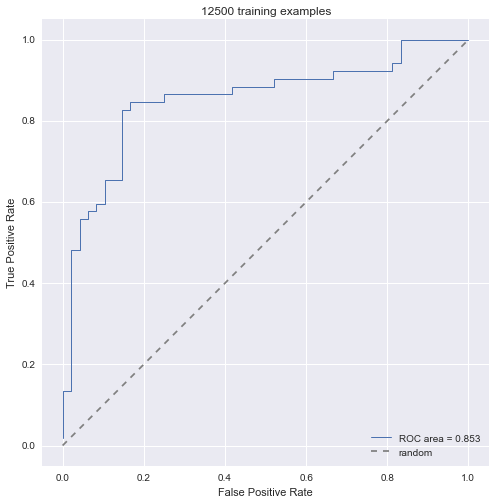

Accuracy: 0.8300


In [24]:
cname = base_model_name + "_sklearn"
plt.figure(figsize=(8,8))
probas_sk = []
y_pred_labels_sk = []
y_pred_sk = []

# get predictions
for i, pred in enumerate(pred_sk):
    proba_pos = proba_sk[i][1]
    probas_sk.append(proba_pos)
    if float(proba_pos) >= 0.50:
        pred_label = "pos"
    elif float(proba_pos) < 0.50:
        pred_label = "neg"
    else:
        print("ERROR on example %d" % i)  # if this happens, need to fix something
    y_pred_labels_sk.append(pred_label)
    y_pred_sk.append(lab2bin[pred_label])

# compute ROC
fpr, tpr, thresholds = metrics.roc_curve(y_true_sk, probas_sk)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw = 1, label = "ROC area = %0.3f" % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5), label='random')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("%d training examples" % len(examples))

plt.legend(loc="lower right")
plt.savefig(os.path.abspath(os.path.join(output_path, cname + "_ROC" + ".png")))
plt.show()

acc = metrics.accuracy_score(y_true_sk, y_pred_sk)
print("Accuracy: %.4f" % (acc))

# Put examples data into batches, for APIs

### Prepare batches of training examples

In [25]:
examples = [list(ex) for ex in zip(df_train['text'], df_train['label'])]
batches = [b for b in batcher(examples, batchsize)]  # stores in memory, but the texts are small so no problem

### Prepare batches of test examples

In [26]:
test_examples = [list(ex) for ex in zip(df_test['text'], df_test['label'])]  # test data
test_batches = [b for b in batcher(test_examples, batchsize)] 

# Strategy B. Pre-trained sentiment HQ

In [27]:
# get predictions from sentiment-HQ API
cname = base_model_name + "hq"
predictions_hq = []
for batch in tqdm(test_batches):
    labels = [x[1] for x in batch]
    texts = [x[0] for x in batch]
    results = indicoio.sentiment_hq(texts)
    for i, result in enumerate(results):
        r = {}
        r['label'] = labels[i]
        r['text'] = texts[i]
        r['proba'] = result
        predictions_hq.append(r)

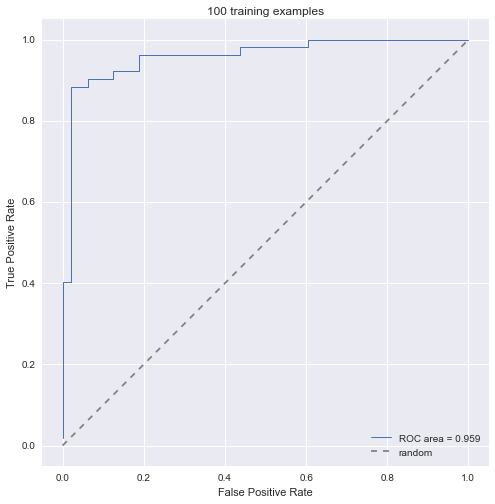

Accuracy: 0.9200


In [28]:
cname = base_model_name + "_hq"
plt.figure(figsize=(8,8))
# y_true = [df_test['label']]
probas = []
y_true = []
y_pred_labels = []
y_pred = []

for i, pred in enumerate(predictions_hq):
    y_true.append(lab2bin[pred['label']])
    proba = pred['proba']
    probas.append(proba)
    if float(proba) >= 0.50:
        pl = 'pos'
    elif float(proba) < 0.50:
        pl= 'neg'
    else:
        print("Error. Check proba value and y_true logic")
    pred_label = pl # pick the most likely class by predicted proba
    y_pred_labels.append(pred_label) 
    y_pred.append(lab2bin[pred_label])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, probas)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw = 1, label = "ROC area = %0.3f" % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5), label='random')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title("ROC plot model: '%s'" % cname)
plt.title("%d training examples" % len(examples))

plt.legend(loc="lower right")
# plt.savefig(os.path.abspath(cname + "_hq_ROC" + ".png"))
plt.savefig(os.path.abspath(os.path.join(output_path, cname + "_ROC" + ".png")))
plt.show()
acc = metrics.accuracy_score(y_true, y_pred)
print("Accuracy: %.4f" % (acc))

# Strategy C. Custom model using general text features.

### Create an indico custom collection using general (word-level) text features, and upload data

In [29]:
cname = base_model_name
print("This model will be cached as an indico custom collection using the name: '%s'" % cname)
collection = Collection(cname)
try:
    collection.clear()  # delete any previous data in this collection
    collection.info()
    collection = Collection(cname)
except:
    print(" Error, probably because a collection with the given name didn't exist. Continuing...")
print(" Submitting %d training examples in %d batches..." % (len(examples), len(batches)))
for batch in tqdm(batches):
    try:
        collection.add_data(batch)
    except Exception as e:
        print("Exception: '%s' for batch:" % e)
        pp.pprint(batch)

print("  training model: '%s'" % cname)
collection.train()
collection.wait() # blocks until the model is trained

This model will be cached as an indico custom collection using the name: 'sentiment_train100_test100'


  0%|          | 0/4 [00:00<?, ?it/s]

 Error, probably because a collection with the given name didn't exist. Continuing...
 Submitting 100 training examples in 4 batches...


  training model: 'sentiment_train100_test100'


In [30]:
# get predictions from the trained API model
predictions = []
cname = base_model_name
collection = Collection(cname)
for batch in tqdm(test_batches):
    labels = [x[1] for x in batch]
    texts = [x[0] for x in batch]
    results = collection.predict(texts)
    for i, result in enumerate(results):
        r = {}
        r['indico_result'] = result
        r['label'] = labels[i]
        r['text'] = texts[i]
        r['proba'] = result['pos']
        predictions.append(r)

In [31]:
pp.pprint(predictions[0])  # sanity check

{   'indico_result': {   u'neg': 0.3364879404, u'pos': 0.6635120596},
    'label': 'pos',
    'proba': 0.6635120596,
    'text': "my personal opinion is that this movie had no real story line to the first john carpenter's vampires but i don't care i loved it. jon bon jovi (derek) was great in this movie. he really mad me believe that he was the person you would never think he was a famous rockstar. there were some bad things about this movie. like the story line,there should have been more to the movie.there should have been a sequel to the movie that followed the movies story line and they should have kept the same main characters in all three vampires movies. i really liked the clothes that the people wore and the setting they pick in mexico. i liked how it was old mexico and not new mexico. with the clay houses and the old fashion churches. i was a little confused with the vampires and how they were able to walk in churches but it was cool how they didn't follow dracula vampire rule

### Draw ROC plot and compute metrics for the custom collection

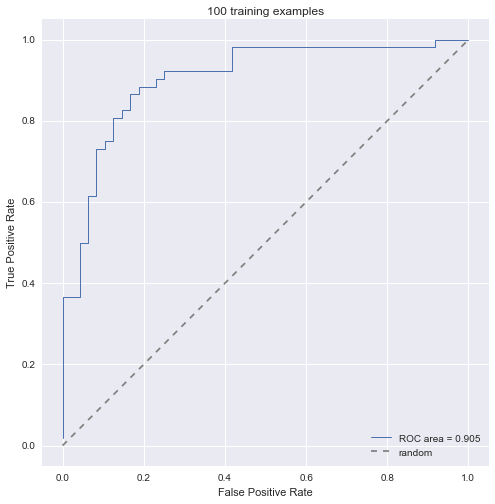

Accuracy: 0.8100


In [32]:
plt.figure(figsize=(8,8))
probas = []
y_true = []
y_pred_labels = []
y_pred = []
for i, pred in enumerate(predictions):
    y_true.append(lab2bin[pred['label']])
    probas.append(pred['indico_result']['pos'])
    pred_label = max(pred['indico_result'].keys(), key = (lambda x: pred['indico_result'][x])) # pick the most likely class by predicted proba
    y_pred_labels.append(pred_label) 
    y_pred.append(lab2bin[pred_label])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, probas)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw = 1, label = "ROC area = %0.3f" % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5), label='random')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("%d training examples" % len(examples))
plt.legend(loc="lower right")
plt.savefig(os.path.abspath(os.path.join(output_path, cname + "_cc_ROC" + ".png")))
plt.show()
acc = metrics.accuracy_score(y_true, y_pred)
print("Accuracy: %.4f" % (acc))

# Strategy D. Custom model using sentiment features from the pretrained deep neural network.

In [33]:
cname = base_model_name + "_domain"
print("This model will be cached as an indico custom collection using the name: '%s'" % cname)
collection = Collection(cname, domain = "sentiment")
try:
    collection.clear()  # delete any previous data in this collection
    collection.info()
    collection = Collection(cname, domain = "sentiment")
except:
    print(" Error, probably because a collection with the given name didn't exist. Continuing...")
print(" Submitting %d training examples in %d batches..." % (len(examples), len(batches)))
for batch in tqdm(batches):
    try:
        collection.add_data(batch, domain = "sentiment")
    except Exception as e:
        print("Exception: '%s' for batch:" % e)
        pp.pprint(batch)

print("  training model: '%s'" % cname)
collection.train()
collection.wait()

This model will be cached as an indico custom collection using the name: 'sentiment_train100_test100_domain'


  0%|          | 0/4 [00:00<?, ?it/s]

 Error, probably because a collection with the given name didn't exist. Continuing...
 Submitting 100 training examples in 4 batches...


  training model: 'sentiment_train100_test100_domain'


### Get predictions for custom collection with sentiment domain text features

In [34]:
# get predictions from trained API
predictions_domain = []
cname = base_model_name + "_domain"
collection = Collection(cname, domain = "sentiment")
for batch in tqdm(test_batches):
    labels = [x[1] for x in batch]
    texts = [x[0] for x in batch]
    results = collection.predict(texts, domain = "sentiment")
#     batchsize = len(batch)
    for i, result in enumerate(results):
        r = {}
        r['indico_result'] = result
        r['label'] = labels[i]
        r['text'] = texts[i]
        r['proba'] = result['pos']
        predictions_domain.append(r)


### Compute metrics and plot

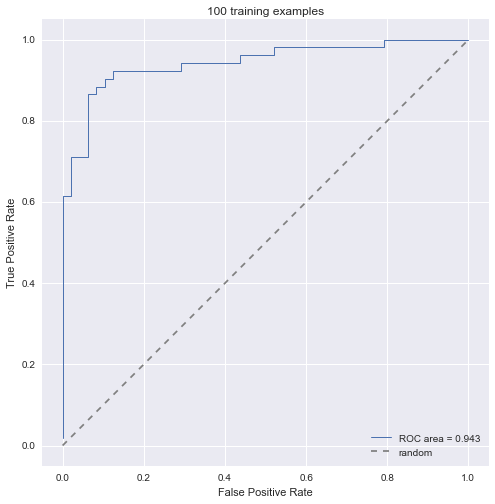

Accuracy: 0.8900


In [35]:
cname = base_model_name + "_domain"
plt.figure(figsize=(8,8))
# y_true = [df_test['label']]
probas = []
y_true = []
y_pred_labels = []
y_pred = []
for i, pred in enumerate(predictions_domain):
    y_true.append(lab2bin[pred['label']])
    probas.append(pred['indico_result']['pos'])
    pred_label = max(pred['indico_result'].keys(), key = (lambda x: pred['indico_result'][x])) # pick the most likely class by predicted proba
    y_pred_labels.append(pred_label) 
    y_pred.append(lab2bin[pred_label])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, probas)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw = 1, label = "ROC area = %0.3f" % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5), label='random')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title("ROC plot model: '%s'" % cname)
plt.title("%d training examples" % len(examples))

plt.legend(loc="lower right")
# plt.savefig(os.path.abspath(cname + "_cc_domain_ROC" + ".png"))
plt.savefig(os.path.abspath(os.path.join(output_path, cname + "_ROC" + ".png")))
plt.show()
acc = metrics.accuracy_score(y_true, y_pred)
print("Accuracy: %.4f" % (acc))

# Sanity check on results for all 4 strategies
Compare the first prediction for each to make sure all the right stuff is there...

In [36]:
print("Strategy A. Custom sklearn model using n-grams, TFIDF, LR:")
print(y_true_sk[0])
print(pred_sk[0])
print(proba_sk[0])
print("")

print("Strategy B. Sentiment HQ:")
pp.pprint(predictions_hq[0])

print("Strategy C. Custom collection using general text features:")
pp.pprint(predictions[0])
print("")

print("Strategy D. Custom collection using sentiment features:")
pp.pprint(predictions_domain[0])
print("")



Strategy A. Custom sklearn model using n-grams, TFIDF, LR:
1
pos
[ 0.31613178  0.68386822]

Strategy B. Sentiment HQ:
{   'label': 'pos',
    'proba': 0.8126749992000001,
    'text': "my personal opinion is that this movie had no real story line to the first john carpenter's vampires but i don't care i loved it. jon bon jovi (derek) was great in this movie. he really mad me believe that he was the person you would never think he was a famous rockstar. there were some bad things about this movie. like the story line,there should have been more to the movie.there should have been a sequel to the movie that followed the movies story line and they should have kept the same main characters in all three vampires movies. i really liked the clothes that the people wore and the setting they pick in mexico. i liked how it was old mexico and not new mexico. with the clay houses and the old fashion churches. i was a little confused with the vampires and how they were able to walk in churches but i

# Compute overall metrics and plot

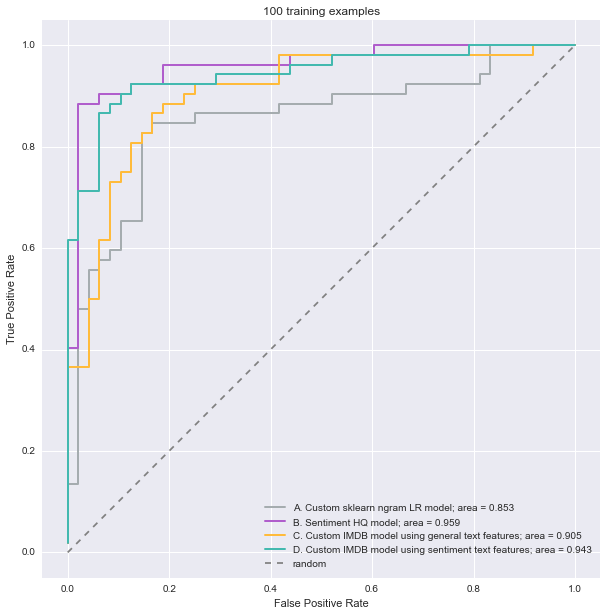

In [39]:
plt.figure(figsize=(10,10))
cname = base_model_name

# compute and draw curve for sklearn LR built from scratch
probas_sk = []
y_pred_labels_sk = []
y_pred_sk = []
for i, pred in enumerate(pred_sk):
    proba_pos = proba_sk[i][1]
    probas_sk.append(proba_pos)
    if float(proba_pos) >= 0.50:
        pred_label = "pos"
    elif float(proba_pos) < 0.50:
        pred_label = "neg"
    else:
        print("ERROR on example %d" % i)    
    y_pred_labels_sk.append(pred_label)
    y_pred_sk.append(lab2bin[pred_label])
fpr_sk, tpr_sk, thresholds_sk = metrics.roc_curve(y_true_sk, probas_sk)
roc_auc_sk = metrics.auc(fpr_sk, tpr_sk)
plt.plot(fpr_sk, tpr_sk, lw = 2, color = "#a5acaf", label = "A. Custom sklearn ngram LR model; area = %0.3f" % roc_auc_sk)

# compute and draw curve for sentimentHQ
probas_s = []
y_true_s = []
y_pred_labels_s = []
y_pred_s = []
for i, pred in enumerate(predictions_hq):
    y_true_s.append(lab2bin[pred['label']])
    probas_s.append(pred['proba'])
    if float(pred['proba']) >= 0.50:
        pred_label = "pos"
    elif float(pred['proba']) < 0.50:
        pred_label = "neg"
    else:
        print("ERROR on example %d" % i)
    y_pred_labels_s.append(pred_label)
    y_pred_s.append(lab2bin[pred_label])
fpr_s, tpr_s, thresholds_s = metrics.roc_curve(y_true_s, probas_s)
roc_auc_s = metrics.auc(fpr_s, tpr_s)
plt.plot(fpr_s, tpr_s, lw = 2, color = "#b05ecc", label = "B. Sentiment HQ model; area = %0.3f" % roc_auc_s)

# Compute and draw curve for the custom collection using general text features
probas = []
y_true = []
y_pred_labels = []
y_pred = []
lab2bin = {'pos': 1,
           'neg': 0}
for i, pred in enumerate(predictions):
    y_true.append(lab2bin[pred['label']])
    probas.append(pred['indico_result']['pos'])
    pred_label = max(pred['indico_result'].keys(), key = (lambda x: pred['indico_result'][x])) # pick the most likely class by predicted proba
    y_pred_labels.append(pred_label) 
    y_pred.append(lab2bin[pred_label])
    
fpr, tpr, thresholds = metrics.roc_curve(y_true, probas)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw = 2, color = "#ffbb3b", label = "C. Custom IMDB model using general text features; area = %0.3f" % (roc_auc))


# now compute and draw curve for the CC using sentiment text features
probas_d = []
y_true_d = []
y_pred_labels_d = []
y_pred_d = []
for i, pred in enumerate(predictions_domain):
    y_true_d.append(lab2bin[pred['label']])
    probas_d.append(pred['indico_result']['pos'])
    pred_label = max(pred['indico_result'].keys(), key = (lambda x: pred['indico_result'][x]))
    y_pred_labels_d.append(pred_label)
    y_pred_d.append(lab2bin[pred_label])
fpr_d, tpr_d, thresholds_d = metrics.roc_curve(y_true_d, probas_d)
roc_auc_d = metrics.auc(fpr_d, tpr_d)
plt.plot(fpr_d, tpr_d, lw = 2, color = "#43b9af", label = "D. Custom IMDB model using sentiment text features; area = %0.3f" % roc_auc_d)


# Add other stuff to figure
plt.plot([0, 1], [0, 1], '--', color=(0.5, 0.5, 0.5), label='random')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title("ROC: %d training examples" % len(examples))
plt.title("%d training examples" % len(examples))

plt.legend(loc="lower right")
plt.savefig(os.path.abspath(os.path.join(output_path, cname + "_comparison_ROC" + ".png")), dpi = 300)
plt.show()

## Accuracy metrics

In [45]:
acc_sk = metrics.accuracy_score(y_true_sk, y_pred_sk)
print("A. Sklearn model from scratch (sklearn) : %.4f" % (acc_sk))

acc_s = metrics.accuracy_score(y_true_s, y_pred_s)
print("B. Sentiment HQ : %.4f" % (acc_s))

acc = metrics.accuracy_score(y_true, y_pred)
print("C. Custom model using general text features : %.4f" % (acc))

acc_d = metrics.accuracy_score(y_true_d, y_pred_d)
print("D. Custom model using sentiment text features : %.4f" % (acc_d))

# print("Using (%d, %d, %d, %d) examples" % (len(y_pred), len(y_pred_d), len(y_pred_s), len(y_pred_sk)))

A. Sklearn model from scratch (sklearn) : 0.8300
B. Sentiment HQ : 0.9200
C. Custom model using general text features : 0.8100
D. Custom model using sentiment text features : 0.8900
